In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from shapely.geometry import Polygon

import cartopy.crs as ccrs 
import cartopy.feature as cfeature
 
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import cKDTree

import matplotlib.animation as animation

from IPython.display import HTML, display

In [2]:
import pygmt

ModuleNotFoundError: No module named 'pygmt'

In [2]:
data_dir = '/Users/jcai/Downloads/SWOT_7_21/'
files = os.listdir(data_dir)


In [3]:
# Setup the new lon-lat grid

lon_new = np.arange(-122 + 360, -127 + 360, -0.03)
lat_new = np.arange(33, 38.5, 0.01)

In [4]:
# Define the latitude and longitude range of interest

lat_min, lat_max = 33, 38.5  # Replace with your actual latitude range
lon_min, lon_max = -127+360, -122+360  # Replace with your actual longitude range

In [5]:
# setup the new lon-lat grid

lon_new = np.arange(-122 + 360, -127 + 360, -0.03)
lat_new = np.arange(33, 38.5, 0.01)
Lon, Lat = np.meshgrid(lon_new, lat_new)

In [6]:
# Setup the s-mode ops region

# Define the latitude and longitude of the turning points
lat_lon_points = [
    (-122.9246513748008,37.00017075060504),
    (-123.3600045167993,37.75374578880221),
    (-124.0035685865631,37.70690473657844),
    (-125.4381962505588,38.11405549886727),
    (-126.2343691354205,38.33265671629315),
    (-125.4928752370857,35.61490575897531),
    (-124.1744291387648,36.00856716614078),
    (-124.3527449926306,36.34480115296711),
    (-122.9246513748008,37.00017075060504),
]

# Create the polygon
polygon = Polygon(lat_lon_points)

# Extract the exterior coordinates of the polygon
exterior_coords = polygon.exterior.coords.xy

In [7]:
def ssha_daily_swot(track_dir_13, track_dir_26, 
                    ssha_alltime, idd,
                    lat_min, lat_max, lon_min, lon_max,
                    Lon, Lat,
                    exterior_coords,
                   ):
    
    # Open the NetCDF file of track 13 ------------------------------------------------------------------
    file_path = track_dir_13
    dataset = xr.open_dataset(file_path)
    
    # select the nadir data
    ssha_nadir = dataset.ssha.isel(num_lines=xr.DataArray(dataset.i_num_line.data, dims="num_nadir"),
                               num_pixels=xr.DataArray(dataset.i_num_pixel.data, dims="num_nadir"))
    
    # Use .where() to filter the data
    ssha_sliced = dataset['ssha'].where(
        (dataset['latitude'] >= lat_min) & (dataset['latitude'] <= lat_max) &
        (dataset['longitude'] >= lon_min) & (dataset['longitude'] <= lon_max),
        drop=True  # Drops the missing values from the result
    )
    
   # also filter the nadir data
    ssha_nadir_sliced = ssha_nadir.where(
        (ssha_nadir['latitude'] >= lat_min) & (ssha_nadir['latitude'] <= lat_max) &
        (ssha_nadir['longitude'] >= lon_min) & (ssha_nadir['longitude'] <= lon_max),
        drop=True  # Drops the missing values from the result
    )
    
    # check out the time range
    time_2 = np.tile(dataset['time'],(ssha_sliced.num_pixels.size,1))
    mask = (dataset['latitude'] >= lat_min) & (dataset['latitude'] <= lat_max)
    
    time_sliced = time_2.T[mask]

    time_min_org = np.min(time_sliced)
    time_str = str(time_min_org)
    time_min = time_str[:19] # shorten the time string

    time_max_org = np.max(time_sliced)
    time_str = str(time_max_org)
    time_max = time_str[:19] # shorten the time string
    
    # Open the NetCDF file of track 26 ------------------------------------------------------------------
    file_path = track_dir_26
    dataset_26 = xr.open_dataset(file_path)
    
    # select the nadir data
    ssha_nadir_26 = dataset_26.ssha.isel(num_lines=xr.DataArray(dataset_26.i_num_line.data, dims="num_nadir"),
                               num_pixels=xr.DataArray(dataset_26.i_num_pixel.data, dims="num_nadir"))
    
    # Use .where() to filter the data
    ssha_26_sliced = dataset_26['ssha'].where(
    (dataset_26['latitude'] >= lat_min) & (dataset_26['latitude'] <= lat_max) &
    (dataset_26['longitude'] >= lon_min) & (dataset_26['longitude'] <= lon_max),
    drop=True  # Drops the missing values from the result
    )
    
    # also filter the nadir data
    ssha_nadir_26_sliced = ssha_nadir_26.where(
        (ssha_nadir_26['latitude'] >= lat_min) & (ssha_nadir_26['latitude'] <= lat_max) &
        (ssha_nadir_26['longitude'] >= lon_min) & (ssha_nadir_26['longitude'] <= lon_max),
        drop=True  # Drops the missing values from the result
    )
    
    # check out the time range
    time_2_26 = np.tile(dataset_26['time'],(ssha_26_sliced.num_pixels.size,1))

    mask = (dataset_26['latitude'] >= lat_min) & (dataset_26['latitude'] <= lat_max)
    
    time_sliced_26 = time_2_26.T[mask]

    time_min_org = np.min(time_sliced_26)
    time_str = str(time_min_org)
    time_min_26 = time_str[:19]


    time_max_org = np.max(time_sliced_26)
    time_str = str(time_max_org)
    time_max_26 = time_str[:19]
    
    # linear interpolate to new lon-lat grid ----------------------------------------------------------------------
    
    # track 13
    xy = np.stack([ssha_sliced.longitude.data.flatten(), ssha_sliced.latitude.data.flatten()]).T
    interp = LinearNDInterpolator(xy, ssha_sliced.data.flatten())
    ssha_gridded = interp(Lon, Lat)

    # track 26
    xy = np.stack([ssha_26_sliced.longitude.data.flatten(), ssha_26_sliced.latitude.data.flatten()]).T
    interp = LinearNDInterpolator(xy, ssha_26_sliced.data.flatten())
    ssha_gridded_26 = interp(Lon, Lat)
    
    # find the closest grid for the nadir data

    # track 13 -----------
    
    # Create a KDTree for the new grid points
    new_grid_points = np.c_[Lat.ravel(), Lon.ravel()]
    tree = cKDTree(new_grid_points)

    # Extract latitude and longitude from ssha_nadir
    lat_nadir = ssha_nadir_sliced.coords['latitude'].values
    lon_nadir = ssha_nadir_sliced.coords['longitude'].values

    # Query the KDTree to find the closest points
    nadir_points = np.c_[lat_nadir.ravel(), lon_nadir.ravel()]
    distances, indices = tree.query(nadir_points)

    # Convert the indices to grid coordinates
    lat_indices, lon_indices = np.unravel_index(indices, Lat.shape)

    # Update ssha_gridded directly
    ssha_gridded.ravel()[indices] = ssha_nadir_sliced.values.ravel()


    # track 26 -----------

    # Extract latitude and longitude from ssha_nadir
    lat_nadir = ssha_nadir_26_sliced.coords['latitude'].values
    lon_nadir = ssha_nadir_26_sliced.coords['longitude'].values

    # Query the KDTree to find the closest points
    nadir_points = np.c_[lat_nadir.ravel(), lon_nadir.ravel()]
    distances, indices = tree.query(nadir_points)

    # Convert the indices to grid coordinates
    lat_indices, lon_indices = np.unravel_index(indices, Lat.shape)

    # Update ssha_gridded directly
    ssha_gridded_26.ravel()[indices] = ssha_nadir_26_sliced.values.ravel()

    
    # find the overlap -----------------------------------------------------------------------------

    a = ~np.isnan(ssha_gridded) # find the non-nan value
    b = ~np.isnan(ssha_gridded_26)
    mask_overlap = a&b # find the location that both track have non-nan value
    
    ssha_gridded_copy = ssha_gridded.copy()
    ssha_gridded_copy[~mask_overlap] = np.nan

    ssha_gridded_copy_26 = ssha_gridded_26.copy()
    ssha_gridded_copy_26[~mask_overlap] = np.nan
    
    # average overlap region
    ssha_overlap_avg = 0.5*(ssha_gridded + ssha_gridded_26)
    
    # create a new array for all data
    ssha_all = np.full((len(lat_new), len(lon_new)), np.nan)

    ssha_all[a] = ssha_gridded[a]
    ssha_all[b] = ssha_gridded_26[b]
    ssha_all[mask_overlap] = ssha_overlap_avg[mask_overlap]

    # save the value! ---------------------------------------------------------------------------
    ssha_alltime[:,:,idd] = ssha_all
    idd = idd + 1
    
    print(time_min)

    return ssha_alltime, time_min, time_max_26, idd

In [8]:
# cycle 474:1:577
# noted: some cycle may only has one track

# Setup the ssha and time_min and time_max to store all daily data

ssha_alltime = np.full((lat_new.shape[0], lon_new.shape[0], 150), np.nan)
# print(ssha_alltime.shape)

time_min_all = []
time_max_all = []

idd = 0


# cycle 491: track 13 no data in the region

for XXX in range(474,507):
    pattern1 = re.compile(rf'SWOT_L3_LR_SSH_Basic_{XXX}_013_.*\.nc')  
    pattern2 = re.compile(rf'SWOT_L3_LR_SSH_Basic_{XXX}_026_.*\.nc')  
    track_dir_13 = [os.path.join(data_dir, f) for f in files if pattern1.match(f)]
    track_dir_26 = [os.path.join(data_dir, f) for f in files if pattern2.match(f)]
    
    # Check if either track_dir_13 or track_dir_26 is empty
    if not track_dir_13 or not track_dir_26:
        # Skip the rest of the loop and continue to the next iteration
        continue
    elif (XXX == 491) | (XXX == 500) | (XXX == 507) :
        continue
        
    
    print(XXX)
    ssha_alltime, time_min, time_max_26, idd = ssha_daily_swot(track_dir_13[0], track_dir_26[0], 
                                                                ssha_alltime, idd,
                                                                lat_min, lat_max, lon_min, lon_max,
                                                                Lon, Lat,
                                                                exterior_coords,
                                                               )
    time_min_all.append(time_min)
    time_max_all.append(time_max_26)


474
2023-03-29T08:50:20
478
2023-04-02T08:12:51
479
2023-04-03T08:03:29
480
2023-04-04T07:54:06
481
2023-04-05T07:44:44
482
2023-04-06T07:35:22
483
2023-04-07T07:26:00
484
2023-04-08T07:16:38
485
2023-04-09T07:07:16
486
2023-04-10T06:57:55
487
2023-04-11T06:48:33
488
2023-04-12T06:39:11
489
2023-04-13T06:29:49
490
2023-04-14T06:20:27
492
2023-04-16T06:01:43
493
2023-04-17T05:52:21
494
2023-04-18T05:42:58
495
2023-04-19T05:33:36
496
2023-04-20T05:24:14
497
2023-04-21T05:14:52
498
2023-04-22T05:05:30
499
2023-04-23T04:56:08
501
2023-04-25T04:37:24
502
2023-04-26T04:28:01
503
2023-04-27T04:18:39
504
2023-04-28T04:09:17
505
2023-04-29T03:59:55
506
2023-04-30T03:50:33


In [9]:
ssha_alltime.shape

(550, 167, 150)

In [10]:
time_min_all

['2023-03-29T08:50:20',
 '2023-04-02T08:12:51',
 '2023-04-03T08:03:29',
 '2023-04-04T07:54:06',
 '2023-04-05T07:44:44',
 '2023-04-06T07:35:22',
 '2023-04-07T07:26:00',
 '2023-04-08T07:16:38',
 '2023-04-09T07:07:16',
 '2023-04-10T06:57:55',
 '2023-04-11T06:48:33',
 '2023-04-12T06:39:11',
 '2023-04-13T06:29:49',
 '2023-04-14T06:20:27',
 '2023-04-16T06:01:43',
 '2023-04-17T05:52:21',
 '2023-04-18T05:42:58',
 '2023-04-19T05:33:36',
 '2023-04-20T05:24:14',
 '2023-04-21T05:14:52',
 '2023-04-22T05:05:30',
 '2023-04-23T04:56:08',
 '2023-04-25T04:37:24',
 '2023-04-26T04:28:01',
 '2023-04-27T04:18:39',
 '2023-04-28T04:09:17',
 '2023-04-29T03:59:55',
 '2023-04-30T03:50:33']

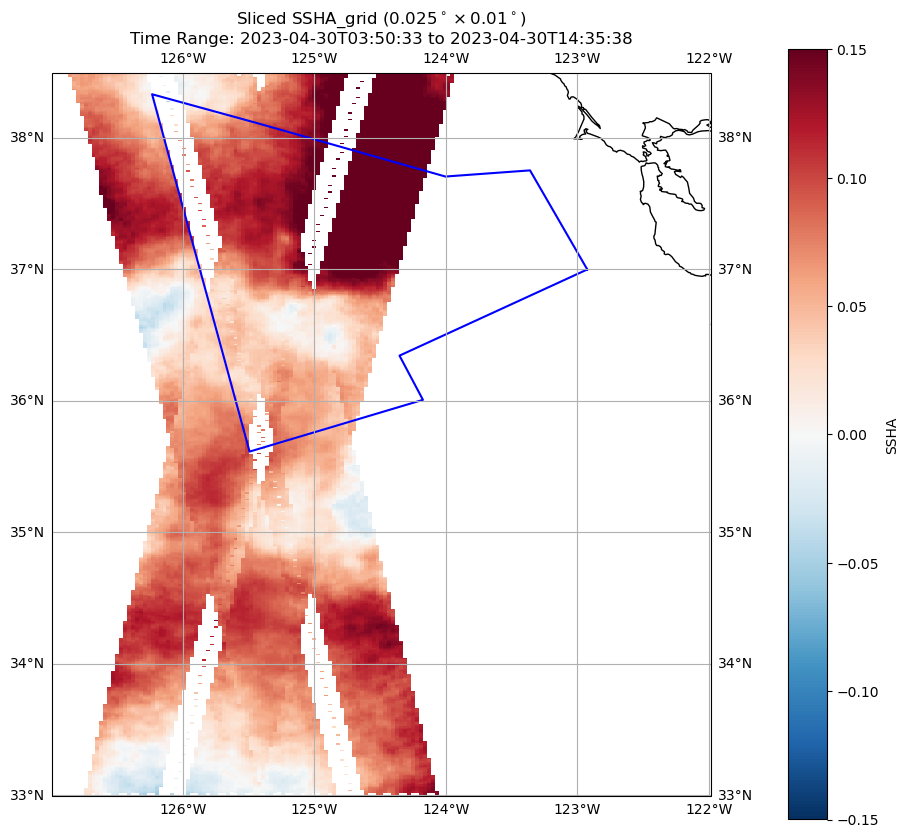

In [11]:
ID = 27

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
ssha_plot = ax.pcolormesh(Lon, Lat, ssha_alltime[:,:,ID], cmap='RdBu_r', shading='auto', vmin=-0.15, vmax=0.15)

# Plot the polygon
ax.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())
# ax.fill(exterior_coords[0], exterior_coords[1], 'b', alpha=0.3, transform=ccrs.PlateCarree())

# Add coastlines and gridlines for better reference
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# Add colorbar
cbar = plt.colorbar(ssha_plot, ax=ax, orientation='vertical', pad=0.1, fraction=0.05)
cbar.set_label('SSHA')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Sliced SSHA_grid ($0.025^\circ \\times 0.01^\circ$) \nTime Range: {time_min_all[ID]} to {time_max_all[ID]}')

plt.show()

In [12]:
len(time_min_all)

28

In [13]:
len(time_max_all)

28

In [14]:
ssha_alltime[:,:,28]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [30]:
# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the polygon
ax.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())

# Plot the data
ssha_plot = ax.contourf(Lon, Lat, ssha_alltime[:, :, 0], cmap='RdBu_r', vmin=-0.15, vmax=0.15)

# Add colorbar
cbar = plt.colorbar(ssha_plot, ax=ax, orientation='vertical', pad=0.1, fraction=0.05)
cbar.set_label('SSHA')
    
# Add coastlines and gridlines for better reference
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Function to update the plot for each frame
def update_frame(XXX):
    global ssha_plot
    for coll in ssha_plot.collections:
        ssha_plot.remove()
    
    # update the plot
    ssha_plot = ax.contourf(Lon, Lat, ssha_alltime[:, :, XXX], cmap='RdBu_r', vmin=-0.15, vmax=0.15)
    
    ax.set_title(f'Sliced SSHA_grid ($0.025^\circ \\times 0.01^\circ$) \nTime Range: {time_min_all[XXX+1]} to {time_max_all[XXX+1]}')
    return ssha_plot

# Create the animation
ani = animation.FuncAnimation(fig, update_frame, frames=range(1,27), interval=1200, repeat_delay=800)



# Save the animation as a movie file
# ani.save('ssha_movie.gif', writer='pillow', fps=2)

# Close the plot
plt.close()

display(HTML(ani.to_jshtml()));

AttributeError: 'GeoContourSet' object has no attribute 'remove'

In [27]:
ani.save('ssha_movie.gif', writer='pillow', fps=2)